# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset
from netCDF4 import date2index
from datetime import datetime

from traj_check import trajcheck
#from traj_plot import traj_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import metpy.calc as mcalc
from metpy.units import units
from station_plot import plot_station
from sounding_finder import sounding_finder
# Loading sounding data at sheba
from sheba_df import sheba_df
from meteo import spec_humidity
from sounding_df import sounding_df as sd
from station_plot import plot_station
from siphon.simplewebservice.igra2 import IGRAUpperAir

%matplotlib inline

/work/ollie/muali/miniconda3/envs/myenv1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/work/ollie/muali/miniconda3/envs/myenv1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [16]:
import matplotlib.gridspec as gridspec

In [1]:
# path to all backward trajectory files
path_traj= '/home/ollie/muali/Data/winter_all/'
# path to single events
path_single = '/home/ollie/muali/data_work/back_traj/Sounding/jan/single_events/all/'
# path forward
path_fwd = '/home/ollie/muali/data_work/back_traj/Sounding/jan/forward_traj/'

In [115]:

def traj_plot_back_fwd(*dates, ax, param_dict=None, path1,path2,  sea_ice='Yes', stations=None, save_fig=None, size=(12,10)\
                       ,rows=7,\
                       levels = ['400', '780', '1000', '1400', '1850', '2850', '3950', '5220', '6730', '8600']):
    
    """Function to plot trajectories for a variable dates for user specified levels with an option for sea_ice
    brackground on a single plot.
    
    Input arguments: 
    date: as a datetime.datetime object Eg, datetime(1997,12,1,23)
    path1: path of backward trajectory file
    path2: path of forward trajectory
    path_save: path where the file is desired to be saved
    sea_ice: 'Yes' or 'Y' to plot sea_ice
    save_fig: Default doesn't save
    rows: No of rows to skip while reading the trajectory data. Default 7 but depends on number of
    Meteo files used while traj 
    calculation
   
    levels: to plot as a list of strings
    Eg, levels = ['400', '780', '1000', '1400', '1850', '2850', '3950', '5220', '6730', '8600'] 
    
    """
    
    
    
    date_str = ['{:%m_%d_%H}'.format(date) for date in dates]
    #print(date_str) 
    
      
    m = Basemap(projection='ortho', lat_0=80, lon_0=270, resolution='l')
    
    m.drawcoastlines(color='0.75')
   
    if (sea_ice == 'Yes' or sea_ice == 'Y'):    
        # Reading Sea Ice data
        filename_ = '/home/ollie/muali/Data/G10010_SeaIce/G10010_SIBT1850_v1.1.nc'
        ds = Dataset(filename_)
        
        # to get the time index out of the netcdf variable
        # change it according to the month you want to plot
        # Eg, dec here
        # timeindex gives you the index of in the netcdf file
        
        timeindex = date2index(datetime(dates[0].year,dates[0].month,15),ds.variables['time'])
        lats_ice = ds.variables['latitude'][:]
        lons_ice = ds.variables['longitude'][:]
    
        #note that lon goes from 0 to 360
        # should we do a -180 here? No, basemap adjusts it automatically
        # creating our meshgrid according to data coordinates given

        lon_ice, lat_ice = np.meshgrid(lons_ice, lats_ice)
        # meshgrid creates a coordinate system with our axis supplied

        # getting seaice for SHEBA december as an eg but it works for all months
        sea_ice_dec = ds.variables['seaice_conc'][timeindex,:,:] # month dependent on user date
        # masking the low seaice concentration value
        # check low sea ice value by np.sea_ice_dec.mina
        # masking since min sea Ice is -1 for continents
        sea_ice_dec = np.ma.masked_where(sea_ice_dec<=0,sea_ice_dec) 
        ds.close()
        
        # plotting Sea Ice
        m.pcolormesh(lon_ice, lat_ice, sea_ice_dec, latlon=True, cmap='Blues')
        plt.clim(0, 100) # Set the color limits of the current image
        plt.colorbar(label='Sea Ice Concentration',fraction=0.046, pad=0.04)
    
########################################################################################################################    
########## Forward Trajectories ################################    
    all_dates = "" # to print dates in the title
    
    # forward trajectory  with green
    for d_ in date_str:
       # print("\n", d_)
        for lvl in levels:
            df = pd.read_csv(path2+'tdump_'+lvl+'_'+d_, skiprows=rows, header=None, delim_whitespace=True)
        
        #taking lat lons of the trajectories to be plotted
            lat = np.array(df.iloc[:, 9].copy())
            lon = np.array(df.iloc[:, 10].copy())
    
        #Convert lat lon to map coordinates
            x, y = m(lon, lat)
    
        #Plot the points on the map
            ax.plot(x, y,linewidth=1.0, color='#00C957') #
            if lvl is levels[-1]:
                ax.plot(x, y,linewidth=1.0, color='#00C957', label='Forward trajectories')
        #source point
            xpt, ypt = m(lon[-1], lat[-1])
            
            # Text
            plt.text(xpt,ypt,lvl, fontsize=8, color='#00C957')
            
            
########################################################################################################################    
########## backward trajectory ################################  
 
    for d_ in date_str:
       # print("\n", d_)
        for lvl in levels:
            df = pd.read_csv(path1+'tdump_'+lvl+'_'+d_, skiprows=rows, header=None, delim_whitespace=True)
        
        #taking lat lons of the trajectories to be plotted
            lat = np.array(df.iloc[:, 9].copy())
            lon = np.array(df.iloc[:, 10].copy())
    
        #Convert lat lon to map coordinates
            x, y = m(lon, lat)
    
        #Plot the trajectories on the map as points
            ax.plot(x, y,linewidth=1.0, color='red')
            
            # labeling single traj to avoid cluttering
            if lvl is levels[-1]:
                plt.plot(x, y,linewidth=1.0, color='red', label='Backward trajectories')
                
        #source point
            xpt, ypt = m(lon[-1], lat[-1])
            
            # Text
            ax.text(xpt,ypt,lvl, fontsize=8, color='red')
            # plt.text(xpt,ypt,'Source (%5.1fW,%3.1fN)' % (lonpt,latpt), color='yellow', fontsize=15)
            
           
        
    #SHEBA point
    x_s, y_s = m(lon[0], lat[0])
    plt.scatter(x_s, y_s, marker = '*', c='#ffed00', edgecolors='k', linewidths=0.5, s=140, \
                label='Observations', zorder=100)
            # plotting only relevant stations
    st_lat = [70.967, 76.0, 68.316] 
    st_lon = [-178.65, 137.866, -133.516]
    
    st_x, st_y = m(st_lon, st_lat)
    plt.scatter(st_x, st_y, marker = '*', c='#ffed00', edgecolors='k', 
                    linewidths=0.7, s=120, zorder=50)
    plt.legend()
    #plt.text(x_s,y_s,'SHEBA', color='#ffed00', fontsize=15)


In [28]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
#gridspec.GridSpec(2,2)

# large subplot
#plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=1) # indexes of rowspan

#traj_plot_back_fwd(datetime(1998,1,4,23), path=path_fwd, pixel=200, stations='Y')

<Figure size 432x288 with 0 Axes>

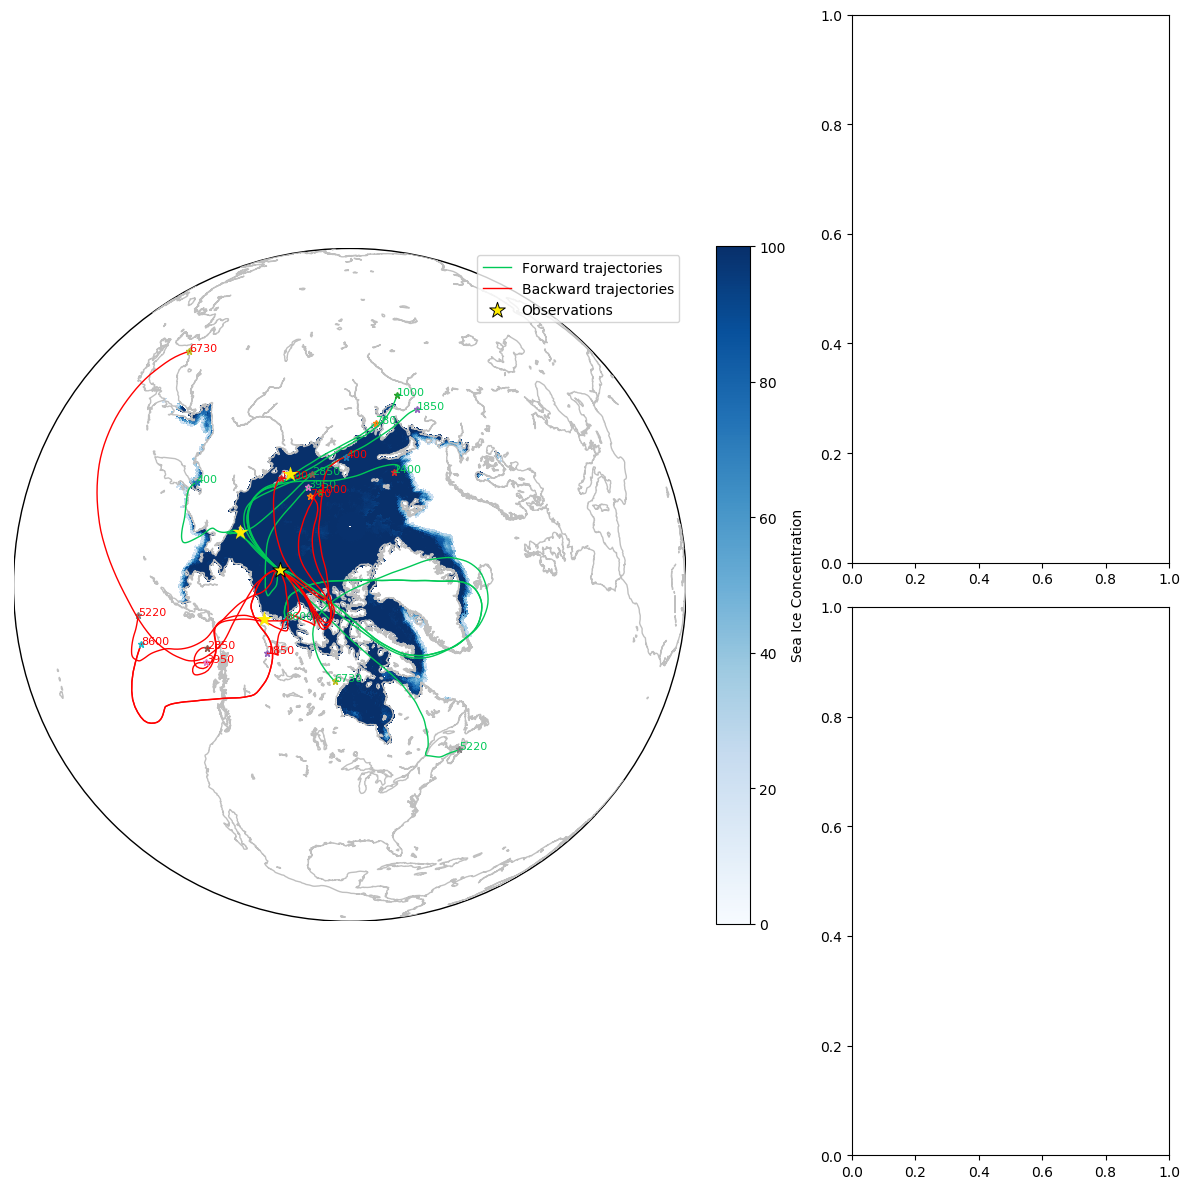

In [62]:
fig = plt.figure(figsize=(12,12), dpi=100)
# set up subplot grid
gridspec.GridSpec(2,3)
# large subplot
ax1 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
# Specify the location of the large subplot: start counting from row 0 column 0 (0,0) and make a subplot 
# across 2 columns and 3 rows colspan=2, rowspan=3. 
# (Remember, Python indexes from 0, so the 3 rows or columns will be indexed as row or column 0, 1, 2.)
traj_plot_back_fwd(datetime(1997,12,7,23), ax=ax1, path1=path_traj, path2=path_fwd, stations='Y')

plt.subplot2grid((2,3), (0,2))
plt.subplot2grid((2,3), (1,2))
plt.tight_layout()

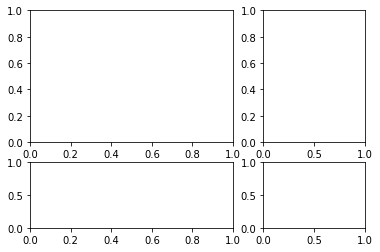

In [53]:
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[2, 1],
                       height_ratios=[2, 1]
                       )

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

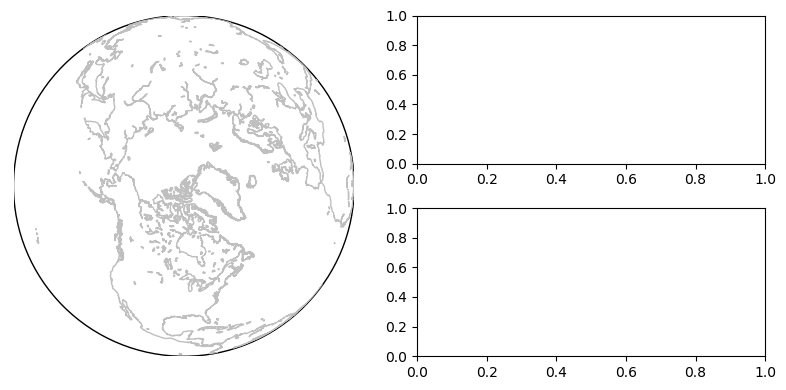

In [68]:
fig = plt.figure(figsize=(8,4), dpi=100)
# set up subplot grid
gridspec.GridSpec(2,2)
# large subplot
ax1 = plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2)
# Specify the location of the large subplot: start counting from row 0 column 0 (0,0) and make a subplot 
# across 2 columns and 3 rows colspan=2, rowspan=3. 
# (Remember, Python indexes from 0, so the 3 rows or columns will be indexed as row or column 0, 1, 2.)
m = Basemap(projection='ortho', lat_0=80, lon_0=270, resolution='l', ax=ax1)
    
m.drawcoastlines(color='0.75', ax=ax1)

plt.subplot2grid((2,2), (0,1))
plt.subplot2grid((2,2), (1,1))
plt.tight_layout()

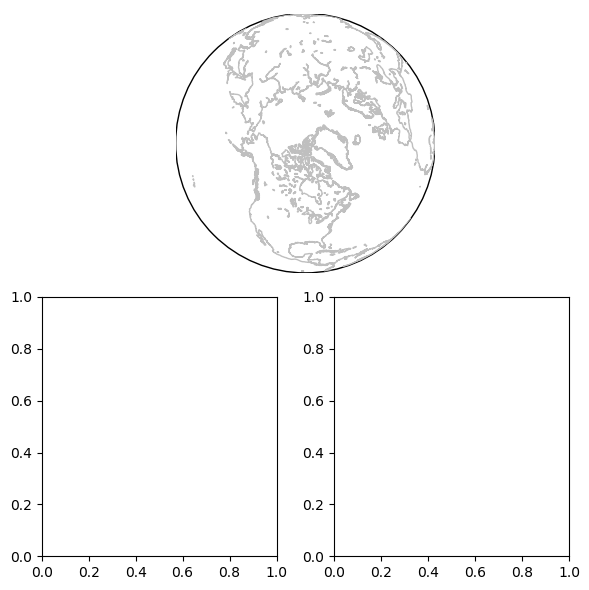

In [87]:
fig = plt.figure(figsize=(6,6), dpi=100)
# set up subplot grid
gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[4,1])
# large subplot
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2, rowspan=1)
# Specify the location of the large subplot: start counting from row 0 column 0 (0,0) and make a subplot 
# across 2 columns and 3 rows colspan=2, rowspan=3. 
# (Remember, Python indexes from 0, so the 3 rows or columns will be indexed as row or column 0, 1, 2.)
m = Basemap(projection='ortho', lat_0=80, lon_0=270, resolution='l', ax=ax1)
    
m.drawcoastlines(color='0.75', ax=ax1)

plt.subplot2grid((2,2), (1,0))
plt.subplot2grid((2,2), (1,1))
plt.tight_layout()

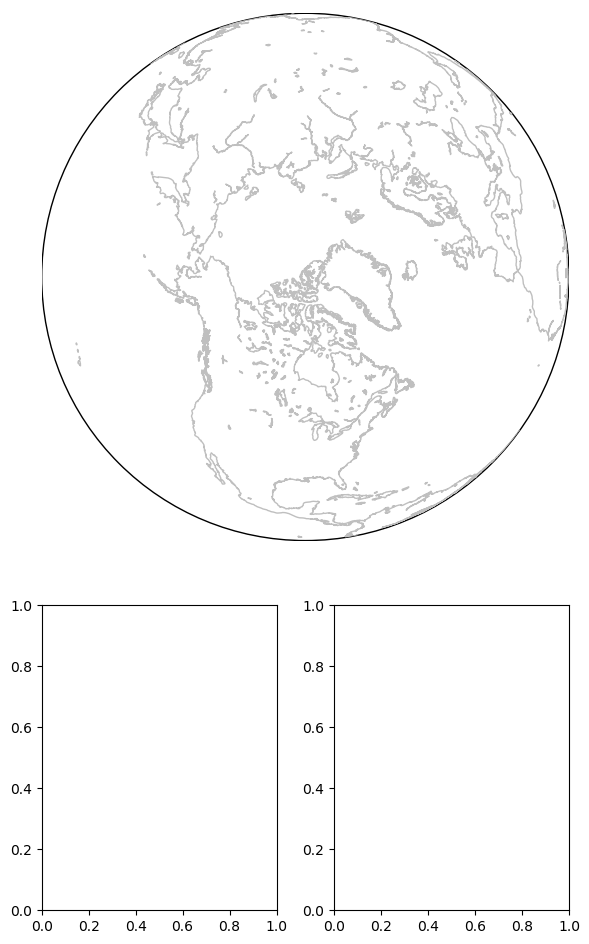

In [91]:
fig = plt.figure(figsize=(6,10), dpi=100)
# set up subplot grid
gridspec.GridSpec(3,2)
# large subplot
ax1 = plt.subplot2grid((3,2), (0,0), colspan=2, rowspan=2)
# Specify the location of the large subplot: start counting from row 0 column 0 (0,0) and make a subplot 
# across 2 columns and 3 rows colspan=2, rowspan=3. 
# (Remember, Python indexes from 0, so the 3 rows or columns will be indexed as row or column 0, 1, 2.)
m = Basemap(projection='ortho', lat_0=80, lon_0=270, resolution='l', ax=ax1)
    
m.drawcoastlines(color='0.75', ax=ax1)

plt.subplot2grid((3,2), (2,0))
plt.subplot2grid((3,2), (2,1))
plt.tight_layout()

In [98]:
# sheba df 13th Jan 11:00
df_she_7_23 = sheba_df('/home/ollie/muali/data_work/Sounding_data/unzipped_data/1997_12_ascii/yc072318.she', dropnan=True)
she7_23 = sd(df_she_7_23)

q_she7_23 = she7_23.spec_humidity()
rh_she7_23 = she7_23.relative_humidity()
rhi_she7_23 = she7_23.relative_humidity_ice()
tpw_she7_23 = she7_23.tpw()
pot_she7_23 = she7_23.potential_t()

# Reading at 12:00
df_RSM00021982 = sounding_finder(file='RSM00021982', from_line='#RSM00021982 1997 12 08',\
                           to_line='#RSM00021982 1997 12 11', to_df=1)
RSM21982 = sd(df_RSM00021982)
q_RSM21982 = RSM21982.spec_humidity()
rh_RSM21982 = RSM21982.relative_humidity()
rhi_RSM21982 = RSM21982.relative_humidity_ice()
pot_RSM21982 = RSM21982.potential_t()
tpw_RSM21982 = RSM21982.tpw(top= 500*units.hectopascal)

#RSM00021432 one reading at 00:00
df_RSM21432 = sounding_finder(file='RSM00021432', from_line='#RSM00021432 1997 12 11',\
                           to_line='#RSM00021432 1997 12 13', to_df=1)
RSM21432 = sd(df_RSM21432)
q_RSM21432 = RSM21432.spec_humidity()
rh_RSM21432 = RSM21432.relative_humidity()
rhi_RSM21432 = RSM21432.relative_humidity_ice()
pot_RSM21432 = RSM21432.potential_t()
tpw_RSM21432 = RSM21432.tpw(top= 576*units.hectopascal) # reading only till 576 hPa

## Main Plot

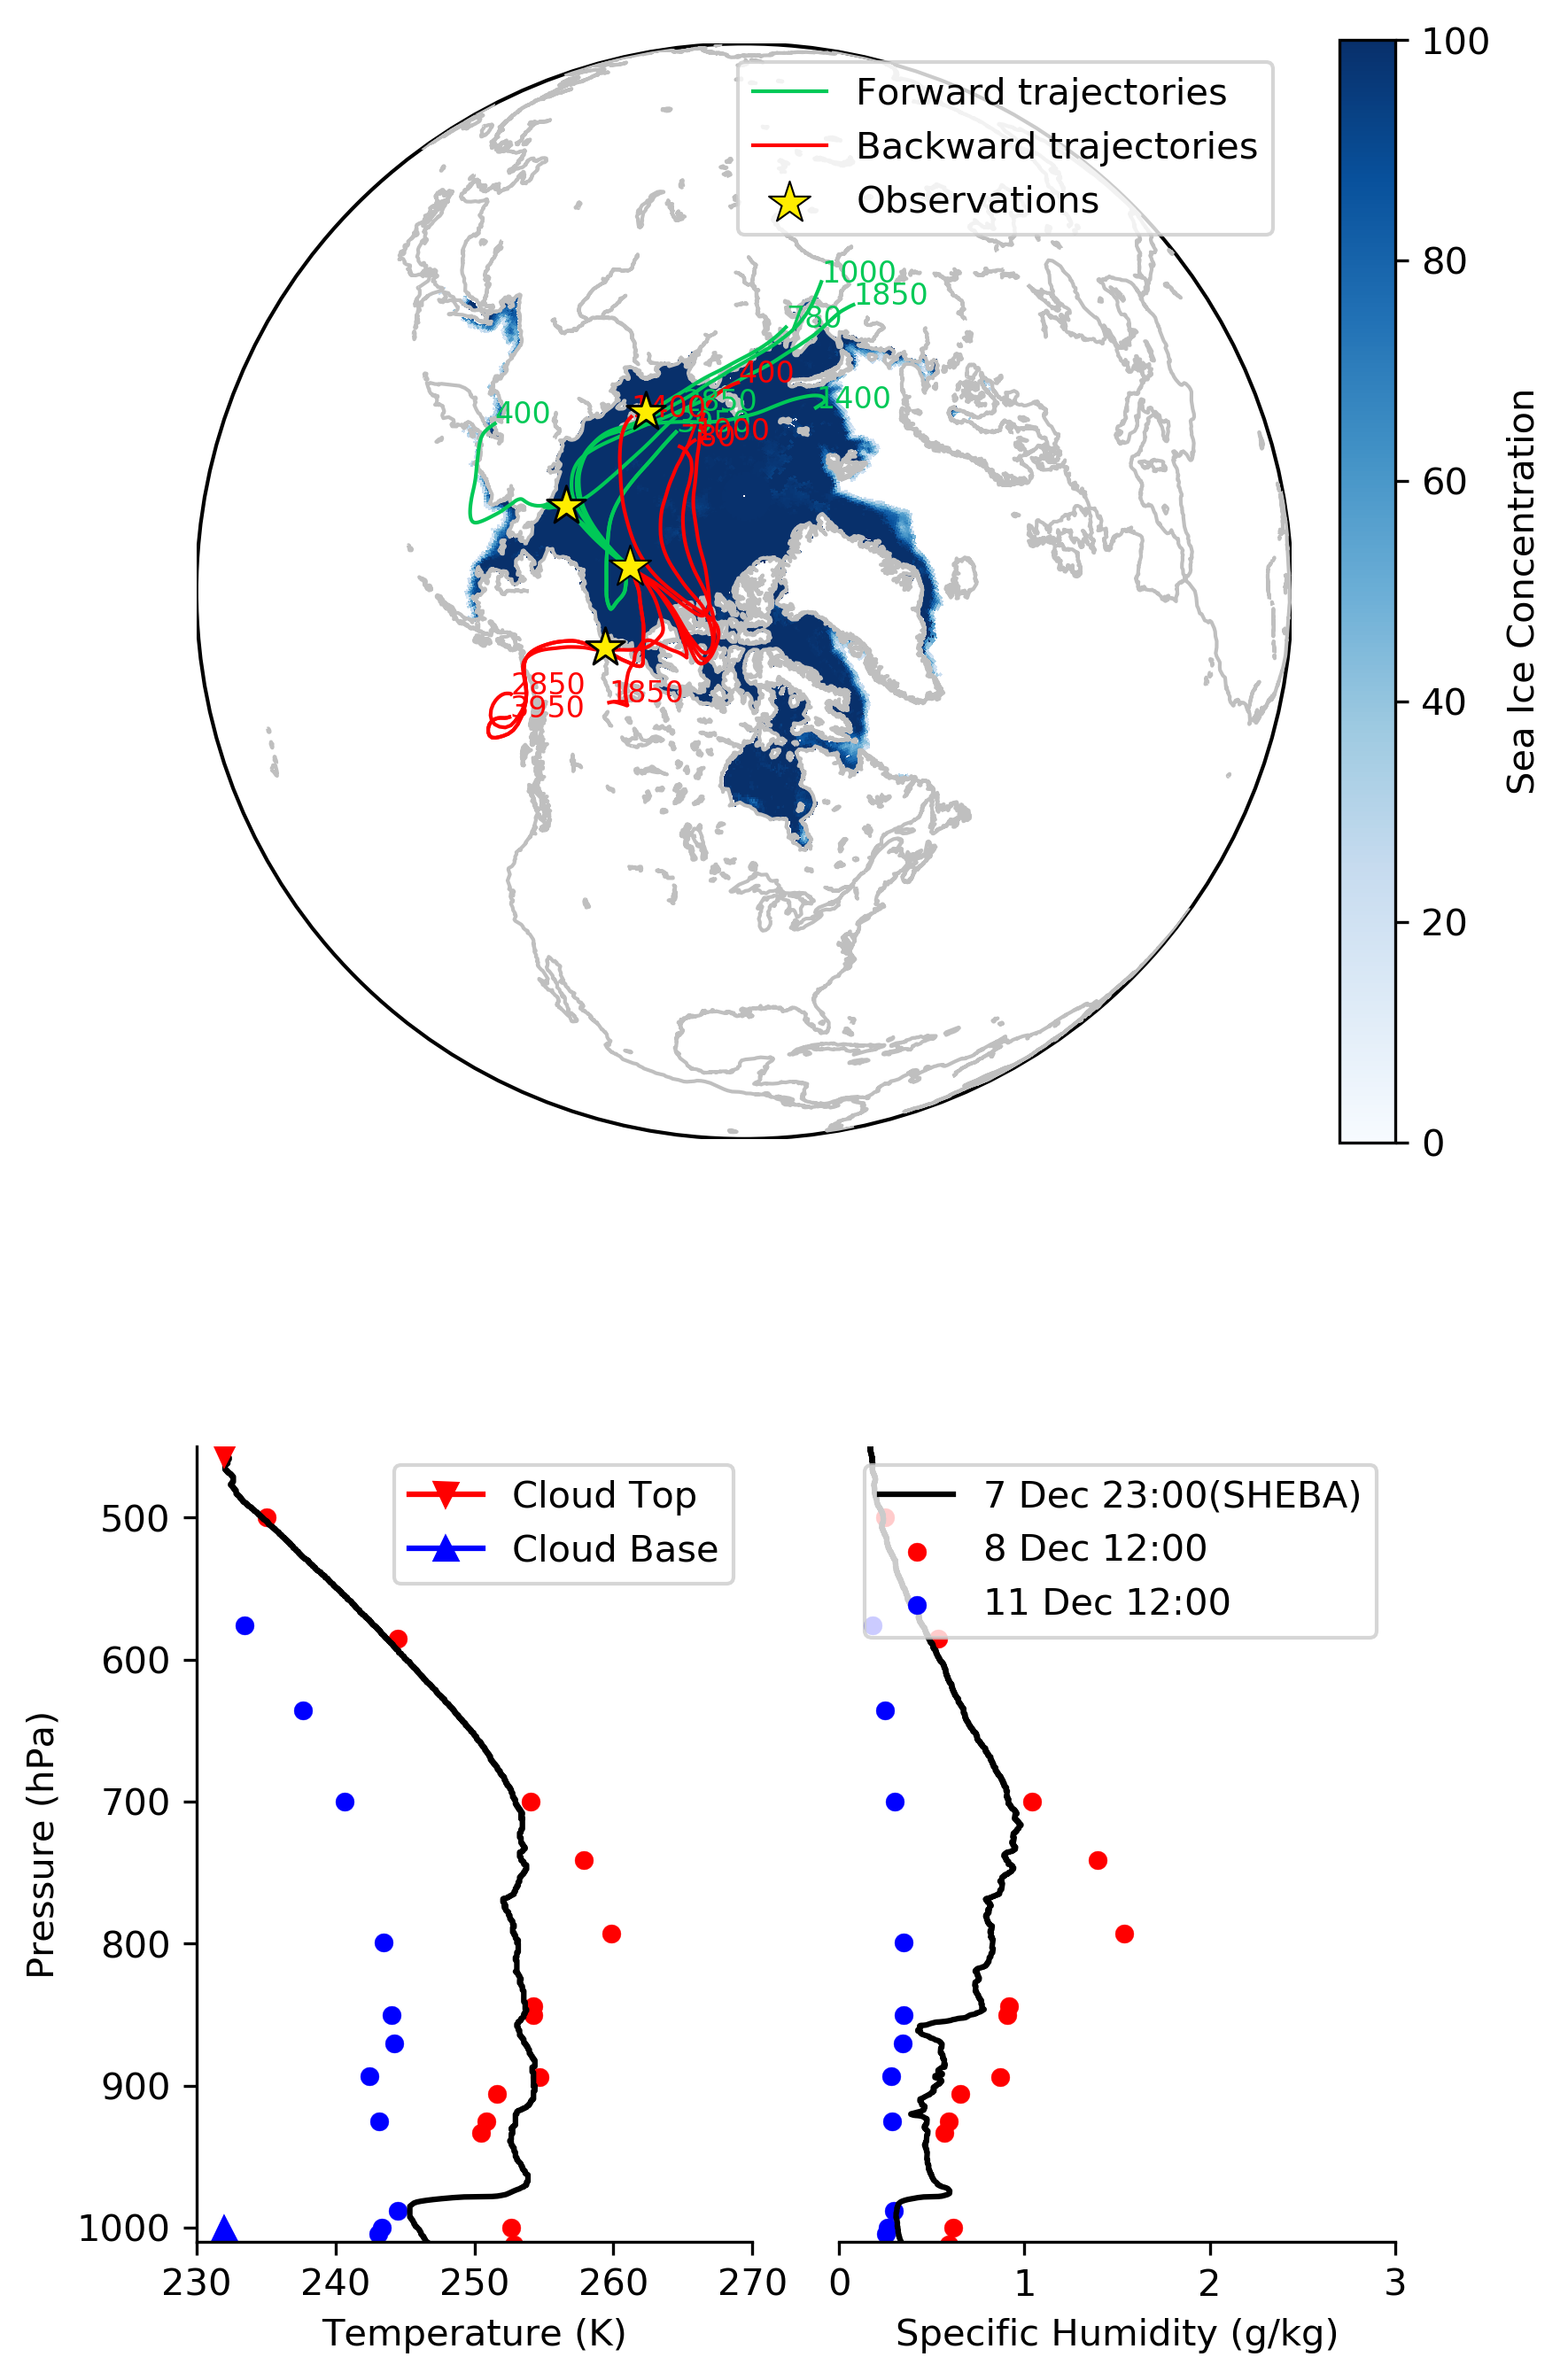

In [125]:
fig = plt.figure(figsize=(6,10), dpi=300)
# set up subplot grid
gridspec.GridSpec(3,2)
# large subplot
ax1 = plt.subplot2grid((3,2), (0,0), colspan=2, rowspan=2)
# Specify the location of the large subplot: start counting from row 0 column 0 (0,0) and make a subplot 
# across 2 columns and 3 rows colspan=2, rowspan=3. 
# (Remember, Python indexes from 0, so the 3 rows or columns will be indexed as row or column 0, 1, 2.)
traj_plot_back_fwd(datetime(1997,12,7,23), ax=ax1, path1=path_traj, path2=path_fwd, stations='Y',
                  levels = ['400', '780', '1000', '1400', '1850', '2850', '3950'])

ax2 = plt.subplot2grid((3,2), (2,0))
ax3 = plt.subplot2grid((3,2), (2,1))



ax2.scatter(RSM21982.T, RSM21982.p,s =25,  marker = 'o', c='r', linewidths=0.1)
ax2.scatter(RSM21432.T, RSM21432.p,s =25, c='b',  marker = 'o', linewidths=0.1)
#ax1.scatter(df_rsm20674_12['temperature'].values +273.15, df_rsm20674_12['pressure'].values, c='g')

ax2.plot(she7_23.T, she7_23.p, c='k' )

ax2.plot([232], [455], marker='v', label = 'Cloud Top', c='r')
ax2.plot([232], [1000.5], marker='^', label = 'Cloud Base', c='b')

ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Pressure (hPa)')
ax2.invert_yaxis()
ax2.set_ylim([1010,450])
ax2.set_xlim([230, 270])

ax2.legend(loc=1)
sns.despine(ax=ax2)




ax3.scatter(q_RSM21982, RSM21982.p,s =25, c='r', marker = 'o', linewidths=0.1, label='8 Dec 12:00')
ax3.scatter(q_RSM21432,  RSM21432.p, s=25, c='b', marker = 'o', label='11 Dec 12:00', linewidths=0.1)
ax3.plot(q_she7_23, she7_23.p, 'k', label='7 Dec 23:00(SHEBA)' )

ax3.set_xlabel('Specific Humidity (g/kg)')
#handles, labels = plt.gca().get_legend_handles_labels()
#order = [2,3,4,0,1]
ax3.legend(loc=1) # setting legend

ax3.invert_yaxis()
ax3.set_ylim([1010,450])
ax3.set_xlim([0,3.0])
#plt.suptitle('Evolution of air mass after the event 7 Dec 23:00', size = 16)
ax3.set_yticklabels([])
ax3.set_yticks([])
sns.despine(ax=ax3, left=True)
plt.tight_layout()
#plt.savefig('/home/ollie/muali/plots_thesis/fwd_prof_7dec23.png', dpi=300)
